In [48]:
import pandas as pd
from sklearn import datasets, linear_model, metrics
import numpy as np
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


In [49]:
train = pd.read_csv('../data/processed/train_data.csv')
test = pd.read_csv('../data/processed/test_data.csv')

In [50]:
#split input and output
X_train=train.drop(['SalePrice'], axis=1)
y_train= train['SalePrice']

X_test=test.drop(['SalePrice'], axis=1)
y_test= test['SalePrice']

In [ ]:
#one hot encoding - convert categorical columns to numerical for linear regression. 
#there was an error with vanishing columns in test. This fixes it. 
X_train_one_hot = pd.get_dummies(X_train, drop_first=True) 
cols = X_train_one_hot.columns.tolist()
X_test_one_hot = pd.get_dummies(X_test, drop_first=True) 
X_test_one_hot = X_test_one_hot.reindex(columns=cols).fillna(0)


In [ ]:
#Linear regression: 
#fit_intercept=False is needed as collinearity of one hot encoding, first row has to be dropped. 
reg = linear_model.LinearRegression(fit_intercept=False)
reg.fit(X_train_one_hot, y_train)

In [ ]:
#predict sales price on test set
predictions_lm = reg.predict(X_test_one_hot)

In [ ]:
#Apply inverse transformation to bring predictions back to the original scale
predictions_lm = np.exp(predictions_lm)

In [ ]:
#RMSE 
rms = mean_squared_error(np.exp(y_test), predictions_lm, squared=False)
rms

In [ ]:
#tensorflow decision trees
#!pip install tensorflow_decision_forests

In [51]:
# Convert the pandas dataframe into a TensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label="SalePrice", task = tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label="SalePrice", task = tfdf.keras.Task.REGRESSION)

In [52]:
# Create a RandomSearch tuner
tuner_rf = tfdf.tuner.RandomSearch(num_trials=20)

tuner_rf.choice("num_trees", [100, 200, 500])
tuner_rf.choice("max_depth", [-1, 10, 30])
tuner_rf.choice("min_examples", [2, 5, 10])

In [53]:
model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, tuner=tuner_rf)
model.compile

Use /var/folders/dw/bq4phr0s4yz1_3vy2_gppjcm0000gp/T/tmpd12jyk8f as temporary training directory


<bound method InferenceCoreModel.compile of <tensorflow_decision_forests.keras.RandomForestModel object at 0x17bbe6d10>>

In [54]:
model.fit(train_ds)

Reading training dataset...


Training dataset read in 0:00:00.335555. Found 1165 examples.
Training model...


I0000 00:00:1736045777.189175 34649845 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1736045777.189187 34649845 kernel.cc:783] Collect training examples
I0000 00:00:1736045777.189191 34649845 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1736045777.189331 34649845 kernel.cc:401] Number of batches: 2
I0000 00:00:1736045777.189335 34649845 kernel.cc:402] Number of examples: 1165
I0000 00:00:1736045777.190395 34649845 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (3 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1736045777.190405 34649845 data_spec_inference.cc:354] 1 item(s) have be

Model trained in 0:00:38.317988
Compiling model...


I0000 00:00:1736045815.470644 34649845 decision_forest.cc:761] Model loaded with 500 root(s), 448772 node(s), and 79 input feature(s).
I0000 00:00:1736045815.470679 34649845 abstract_model.cc:1404] Engine "RandomForestOptPred" built
2025-01-04 21:56:55.470704: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


Model compiled.


In [56]:
tuning_logs_rf = model.make_inspector().tuning_logs()
# Best hyper-parameters.
tuning_logs_rf[tuning_logs_rf.best].iloc[0]

score              -0.135769
evaluation_time    19.502594
best                    True
num_trees                500
max_depth                 30
min_examples               2
Name: 11, dtype: object

In [57]:
model.compile(metrics=["accuracy"])
print(model.evaluate(test_ds))

1/1 [==============================] - 0s 174ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
[0.0, 0.0]


In [58]:
inspector = model.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1165, accuracy=None, loss=None, rmse=0.1357687319909386, ndcg=None, aucs=None, auuc=None, qini=None)

In [59]:
#note this RMSE is on the logarmithic data, not the actual data! 

In [60]:
#calculate the actual RMSE
preds = model.predict(test_ds)

1/1 [==============================] - 0s 114ms/step


In [61]:
predics=np.exp(preds)
y=test['SalePrice']

In [62]:
rms = mean_squared_error(np.exp(y), preds, squared=False)
rms

TypeError: got an unexpected keyword argument 'squared'

In [63]:

#next acitivity, explore all of these methods and compare RMSE of all

tfdf.keras.get_all_models()


[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [64]:
#GradientBoostedTreesModel - work in progress

In [65]:
# Create a RandomSearch tuner
tuner_gb = tfdf.tuner.RandomSearch(num_trials=10)

tuner_gb.choice("num_trees", [50, 100, 200, 500, 1000])
tuner_gb.choice("shrinkage", [0.01, 0.05, 0.1, 0.3, 0.5])
tuner_gb.choice("max_depth", [3, 4, 5, 6, 8, 10])
tuner_gb.choice("min_examples", [2, 5, 10, 15])



In [66]:
# Initialize and train Gradient Boosted Trees Regression model
model_gb_regressor = tfdf.keras.GradientBoostedTreesModel(
    task=tfdf.keras.Task.REGRESSION,
    tuner=tuner_gb
)

model_gb_regressor.fit(train_ds)
print("Model training complete.")

Use /var/folders/dw/bq4phr0s4yz1_3vy2_gppjcm0000gp/T/tmpeo43ujq_ as temporary training directory
Reading training dataset...


2025-01-04 21:57:57.364920: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-01-04 21:57:57.364948: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-01-04 21:57:57.364955: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.324651. Found 1165 examples.
Training model...


I0000 00:00:1736045877.699090 34649845 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1736045877.699102 34649845 kernel.cc:783] Collect training examples
I0000 00:00:1736045877.699106 34649845 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1736045877.699227 34649845 kernel.cc:401] Number of batches: 2
I0000 00:00:1736045877.699231 34649845 kernel.cc:402] Number of examples: 1165
I0000 00:00:1736045877.700276 34649845 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (3 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1736045877.700287 34649845 data_spec_inference.cc:354] 1 item(s) have be

Model trained in 0:00:04.671342
Compiling model...


I0000 00:00:1736045882.230478 34743084 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.155994
2025-01-04 21:58:02.230506: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 468 tree(s) i.e. 468  iteration(s).
2025-01-04 21:58:02.230643: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:468 valid-loss:0.155994 valid-rmse:0.155994
2025-01-04 21:58:02.238736: I external/ydf/yggdrasil_decision_forests/learner/hyperparameters_optimizer/hyperparameters_optimizer.cc:578] [9/10] Score: -0.155994 / -0.14243 HParams: fields { name: "num_trees" value { integer: 1000 } } fields { name: "shrinkage" value { real: 0.01 } } fields { name: "max_depth" value { integer: 10 } } fields { name: "min_examples" value { integer: 15 } }
2025-01-04 21:58:02.239054: I external/ydf/yggdrasil

Model compiled.


Model training complete.


In [67]:
tuning_logs_gb = model_gb_regressor.make_inspector().tuning_logs()
# Best hyper-parameters.
tuning_logs_gb[tuning_logs.best].iloc[0]

score              -0.14243
evaluation_time    0.745678
best                   True
num_trees                50
shrinkage               0.3
max_depth                 4
min_examples              2
Name: 3, dtype: object

In [68]:
# Make predictions on test dataset
predictions_gb_log = model_gb_regressor.predict(test_ds)

# Reverse log transformation for predictions
y_pred_gb = np.exp(predictions_gb_log)

# Reverse the log transformation for true variable
y_true_gb = np.exp(y_test)

1/1 [==============================] - 0s 97ms/step


In [69]:
# Calculate RMSE and evaluate model performance
rmse_gb = np.sqrt(mean_squared_error(y_true_gb, y_pred_gb))
print(f"Root Mean Squared Error (RMSE): {rmse_gb:.2f}")

Root Mean Squared Error (RMSE): 26493.45


In [70]:
#Cart model

In [71]:
#train model
model_cm_regression = tfdf.keras.CartModel(task=tfdf.keras.Task.REGRESSION)

model_cm_regression.fit(train_ds)

Use /var/folders/dw/bq4phr0s4yz1_3vy2_gppjcm0000gp/T/tmpvc8vmlf7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.324409. Found 1165 examples.
Training model...
Model trained in 0:00:00.036815
Compiling model...


I0000 00:00:1736045895.522747 34649845 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1736045895.522761 34649845 kernel.cc:783] Collect training examples
I0000 00:00:1736045895.522765 34649845 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1736045895.522880 34649845 kernel.cc:401] Number of batches: 2
I0000 00:00:1736045895.522884 34649845 kernel.cc:402] Number of examples: 1165
I0000 00:00:1736045895.523895 34649845 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (3 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1736045895.523907 34649845 data_spec_inference.cc:354] 1 item(s) have be

Model compiled.


In [72]:
# Make predictions on the same dataset (or test set)
predictions_log_cm = model_cm_regression.predict(train_ds)

# Reverse the log transformation (use np.exp to get the original scale)
predictions_original_scale_cm = np.exp(predictions_log_cm)


2/2 [==============================] - 0s 3ms/step


In [74]:
rms = mean_squared_error(y_true, predictions_original_scale_cm, squared=False)
rms

TypeError: got an unexpected keyword argument 'squared'

In [75]:
#basic RF

In [76]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0, oob_score=True)
regressor.fit(X_train_one_hot, y_train)

RandomForestRegressor(oob_score=True, random_state=0)

In [77]:
predictions_rf = regressor.predict(X_test_one_hot)
mse = mean_squared_error(np.exp(y_test), np.exp(predictions))
print(f'Mean Squared Error: {mse}')

NameError: name 'predictions' is not defined

NameError: name 'y_true' is not defined

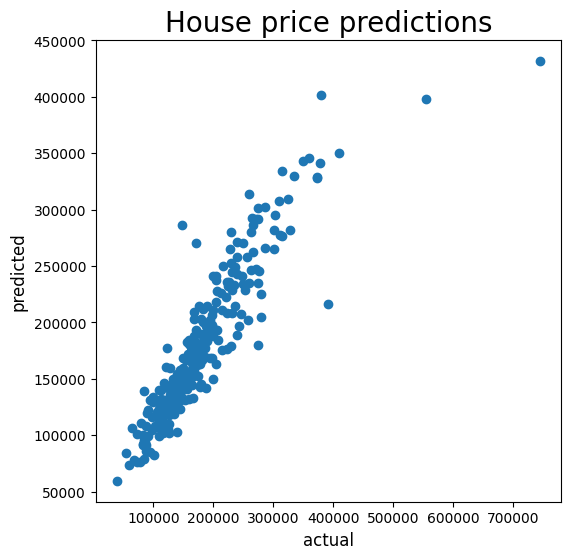

In [78]:
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title('House price predictions',fontsize=20)
    ax.set_ylabel('predicted',fontsize=12)
    ax.set_xlabel('actual',fontsize=12)
    ax.scatter(np.exp(y_test), np.exp(predictions_rf),label='Random Forest')
    ax.scatter(y_true, predictions_original_scale_cm,label='Cart model')
    ax.scatter(y_true, predictions_original_scale,label='GradientBoostedTreesModel')
    ax.scatter(np.exp(y_test), predictions_lm,label='Linear model')
    ax.legend()
